# Logistic Regression Using Retail Relay Data

This notebook will demonstrate predicting customer retention using logistic regression.

Assignment Questions:

1. Use the Relay data to develop a model to predict customer retention. You may use logistic regression to predict the variable “retained.” You can use any combination of the independent variables available in the data to obtain a model
with the best predictive ability and usability. You are free to use different transformations and combinations of the independent variables. Be aware that there is no “magic bullet” to finding the ideal model. You will have to go through multiple iterations.

2. Split the data into test and train. Generally, 70% of the data is used to train the model and a hold out sample of 30% is used to test the accuracy of the model.

3. Create the first model with all the variables that can be used in the given data set. Interpret the coefficients in a real-world sense.

4. Once you obtain the best model that you can find, predict retention in the test data. You will use the logistic regression coefficients obtained from the train data to do this. This new variable will be the predicted value of retained.

5. Calculate the hit rate. This can be calculated as % of matches between the value of the variable “retained” and the predicted value of “retained” in the test data.


In [188]:
import os
import pandas as pd 
import numpy as np 
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from statsmodels.graphics.mosaicplot import mosaic
plt.rc('font', size = 14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns 
sns.set(style = 'white')
sns.set(style = 'whitegrid', color_codes = True)
#import warnings
#warnings.filterwarnings('ignore', category = FutureWarning)

## Read Data

In [189]:
fname = "Relay_Data.xlsx"
df = pd.read_excel(fname, sheet_name=2)

In [190]:
# top 5 observations
df.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,2008-09-27,2009-08-10 00:00:00,2009-08-10 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,CHO
1,APCENR,1,2006-12-18,2007-03-31 00:00:00,2010-01-18 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,CHO
2,7UP6MS,0,2006-10-02,2006-11-30 00:00:00,2007-07-05 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,CHO
3,7ZEW8G,0,2006-10-21,2007-03-27 00:00:00,2007-03-27 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,RIC
4,8V726M,1,2006-11-26,2006-11-28 00:00:00,2009-01-27 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,RIC


In [191]:
# bottom 5 observations
df.tail()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
30796,24CY2D,1,2014-01-16,2014-01-16 00:00:00,2014-01-16 00:00:00,6,83.333333,16.666667,55.68,0.0,1,0,1,Friday,DCX
30797,YQK8BU,1,2014-01-16,2014-01-16 00:00:00,2014-01-16 00:00:00,13,69.230769,7.692308,35.00,0.0,1,0,0,Saturday,DCX
30798,TFQRQP,1,2014-01-16,2014-01-16 00:00:00,2014-01-20 00:00:00,8,75.000000,37.500000,52.03,0.5,1,1,0,Saturday,DCX
30799,ZTXM5Y,1,2014-01-16,2014-01-16 00:00:00,2014-01-16 00:00:00,6,33.333333,0.000000,40.20,0.0,1,0,0,Friday,RIC
30800,HXF9P5,1,2014-01-16,2014-01-16 00:00:00,2014-01-16 00:00:00,5,40.000000,20.000000,40.00,0.0,1,0,0,Friday,DCX


### 

In [192]:
df.shape

(30801, 15)

In [193]:
# columns and their data types
df.dtypes

custid                object
retained               int64
created       datetime64[ns]
firstorder            object
lastorder             object
esent                  int64
eopenrate            float64
eclickrate           float64
avgorder             float64
ordfreq              float64
paperless              int64
refill                 int64
doorstep               int64
favday                object
city                  object
dtype: object

### The dataset contains 30801 observations of 15 variables
* The target variable is called 'retained'
* There are several variables that may not be useful to include in the regression model itself such as:
    * custid (ID), created (Datetime), firstorder (Datetime), lastorder (Datetime)
    * firstorder and lastorder should be Datetime format, but they come encoded as 'object' type.
    * Although these may not end up in the regression model, it might be good to explore the data visually using these variables in conjunction with the target variable 'retained'. 
* Some preprocessing and exploration is definitely in scope given the data.
* There are two 'object' type variables 'favday' and 'city', which may be useful to include in the regression model. These should be one-hot-encoded to create dummy variables for modeling.

## Data Dictionary
* **custid**:       Computer generated ID to identify customers throughout the database
* **retained**:     1, if customer is assumed to be active, 0 = otherwise
* **created**:	    Date when the contact was created in the database - when the customer joined
* **firstorder**:	Date when the customer placed first order
* **lastorder**:	Date when the customer placed last order
* **esent**:    	Number of emails sent
* **eopenrate**:	Number of emails opened divided by number of emails sent
* **eclickrate**:	Number of emails clicked divided by number of emails sent
* **avgorder**: 	Average order size for the customer
* **ordfreq**:  	Number of orders divided by customer tenure
* **paperless**:	1 if customer subscribed for paperless communication (only online)
* **refill**:   	1 if customer subscribed for automatic refill
* **doorstep**: 	1 if customer subscribed for doorstep delivery
* **favday**:   	Customer's favorite delivery day
* **city**:     	City where the customer resides in


## Validate 'custid' is unique

In [194]:
print("There are {:d} total observations".format(df.shape[0]))

There are 30801 total observations


In [195]:
print("There are {:d} unique customer ids".format(len(set(df.custid))))

There are 30770 unique customer ids


### Customer ID is in fact not the unique identifier of this dataset

## Check for Missing Data

In [196]:
# count of missing values by column
df.isna().sum()

custid        20
retained       0
created       20
firstorder    20
lastorder     20
esent          0
eopenrate      0
eclickrate     0
avgorder       0
ordfreq        0
paperless      0
refill         0
doorstep       0
favday         0
city           0
dtype: int64

### There are exactly 20 missing values in each of these variables:
* 'custid','created','firstorder','lastorder'
* The following observations contain missing values in these variables
* For the purposes of this demonstration, these observations will still be used for logistic regression modeling as the target variable and proposed independent variables do not contain any missing values.

In [197]:
missing_data = df[df.isnull().any(axis = 1)]
missing_data.shape

(20, 15)

## Check for duplicate observations

In [198]:
df = df.reset_index()
df.loc[df.duplicated(keep = False)]

,index,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city


### The dataset does not contain any duplicated observations

## Count of unique values by variable

In [199]:
[col + ' ' + str(df[col].nunique()) for col in list(df.columns)]

['index 30801',
 'custid 30769',
 'retained 2',
 'created 2821',
 'firstorder 2672',
 'lastorder 2414',
 'esent 90',
 'eopenrate 977',
 'eclickrate 503',
 'avgorder 9937',
 'ordfreq 4388',
 'paperless 2',
 'refill 2',
 'doorstep 2',
 'favday 7',
 'city 4']

### The following independent variables are categorical in nature:
* 'paperless' - binary
* 'refill 2' - binary
* 'doorstep' - binary
* 'favday' - categorical 7-levels
* 'city' - categorical 4-levels

## Check for Class Imbalance in Target Variable 'retained'

In [200]:
df['retained'].value_counts()

1    24472
0     6329
Name: retained, dtype: int64

In [201]:
24472 / (24472+6329)

0.7945196584526476

### There is a class imbalance in the Target Variable 'retained'. 80% of observations are 'retained' = 1; 20% of observations are 'retained' = 0. Due to the class imbalance, it will be necessary to perform resampling to balance the classes prior to modeling.

## Explore Average Values by Class
* For each target class label, compute the average value of each independent variable

In [202]:
df.columns

Index(['index', 'custid', 'retained', 'created', 'firstorder', 'lastorder',
       'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless',
       'refill', 'doorstep', 'favday', 'city'],
      dtype='object')

In [203]:
# variables for modeling
these_vars = ['retained','esent','eopenrate','eclickrate','avgorder','ordfreq']
df[these_vars].groupby('retained').mean()

,esent,eopenrate,eclickrate,avgorder,ordfreq
retained,,,,,
0,4.496919,21.207903,4.785196,61.550188,0.035523
1,34.252615,26.679051,5.900263,61.957675,0.038299


### On average:
* 'esent' (number of emails sent to customer) is substantially higher for retained customers than for non-retained customers.
    * **Retained customers were sent 34 emails on average versus 4 emails for non-retained customers**
* 'eopenrate' (emails opened) and 'eclickrate' (emails clicked) are slightly higher as well for retained customers than for non-retained customers.
* 'avgorder' (average order size) is similar for retained customers and non-retained customers. This doesn't appear to be a very distinguishing factor.
* 'ordfreq' (ratio of number of orders to customer tenure) is also similar between retained and non-retained customers.


## Visualize Distributions of Variables by Retained and Non-Retained Customers
* For each of the variables ('esent','eopenrate','eclickrate','avgorder','ordfreq') assess how different the distributions are for retained vs. non-retained customers

### Number of Emails Sent by 'retained'

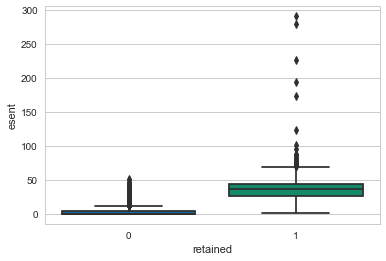

In [204]:
sns.boxplot(y = 'esent', x = 'retained', data = df, palette='colorblind')

### From the visualization, there does appear to be a significant difference in the number of emails sent to the customer between classes.

### Number of Emails Opened by 'retained'

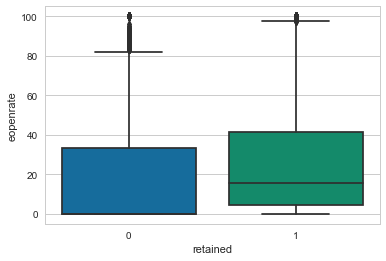

In [205]:
sns.boxplot(y = 'eopenrate', x = 'retained', data = df, palette = 'colorblind')

### From the visualization, there does appear to be a significant difference in the number of emails opened between classes, but also exhibits a lot of uncertainty due to the overlapping interquartile ranges of the distributions.

### Number of Emails Clicked by 'retained'

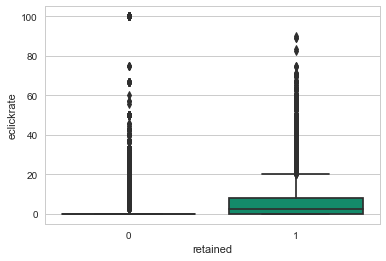

In [206]:
sns.boxplot(y = 'eclickrate', x = 'retained', data = df, palette = 'colorblind')

### From the visualization, there does appear to be a significant difference in the number of emails clicked between classes.

### Average Order Size by 'retained'

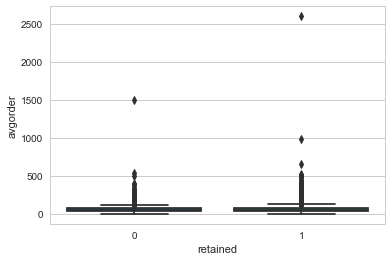

In [207]:
sns.boxplot(y = 'avgorder', x = 'retained', data = df, palette = 'colorblind')

### From the visualization, there doesn't appear to be a significant difference in average order size between classes.

### Order Frequency by 'retained'

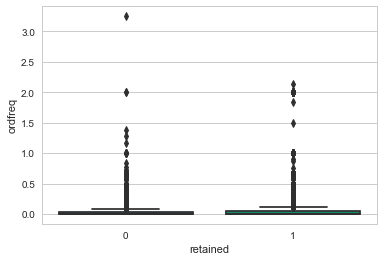

In [208]:
sns.boxplot(y = 'ordfreq', x = 'retained', data = df, palette = 'colorblind')

### From the visualization, there doesn't appear to be a significant difference in order frequency between classes.

## Confirm differences between classes using T-Test

In [209]:
from scipy import stats
varlist = ['esent','eopenrate','eclickrate','avgorder','ordfreq']
for var in varlist:
    t, p = stats.ttest_ind(
        df.loc[df.retained == 0, var],
        df.loc[df.retained == 1, var]
    )
    print("variable:", var)
    print("t statistic:", t)
    print("p-value:", p)

variable: esent
t statistic: -180.89462305072567
p-value: 0.0
variable: eopenrate
t statistic: -13.162777366556822
p-value: 1.837014936383566e-39
variable: eclickrate
t statistic: -7.493341815298212
p-value: 6.894234497759226e-14
variable: avgorder
t statistic: -0.7046374399870672
p-value: 0.4810412207444854
variable: ordfreq
t statistic: -1.893633175285251
p-value: 0.058283079637714834


### The t-tests show that the mean differences in the variables 'esent', 'eopenrate', and 'eclickrate' are significantly different from zero between retained and non-retained customers. 
* Although the p-values show statistical significance in each case, there is a large contrast between the t statistic for 'esent' compared to the others. 
* This may informally indicate that 'esent' is the biggest factor in distinguising retained versus non-retained.

## Create a new variable 'orddiff'
* This is the difference in days between first order and last order date
* This may be a proxy variable for customer tenure, which isn't available in this dataset.

In [210]:
# difference in days between first order and last order date
orddiff = pd.to_datetime(df['lastorder'], errors = 'coerce') - pd.to_datetime(df['firstorder'], errors = 'coerce')
df['orddiff'] = orddiff

In [211]:
# orddiff summary for whole dataset
df.orddiff.describe()

count                       30747
mean      90 days 13:58:50.451751
std      223 days 04:24:11.923719
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%              46 days 00:00:00
max            1985 days 00:00:00
Name: orddiff, dtype: object

In [212]:
# orddiff summary for non-retained customers
df.loc[df.retained == 0, 'orddiff'].describe()

count                        6314
mean      86 days 13:24:36.718403
std      213 days 16:15:30.795911
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%              42 days 00:00:00
max            1763 days 00:00:00
Name: orddiff, dtype: object

In [213]:
# orddiff summary for retained customers
df.loc[df.retained == 1, 'orddiff'].describe()

count                       24433
mean      91 days 14:56:11.473007
std      225 days 13:37:09.366103
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%              47 days 00:00:00
max            1985 days 00:00:00
Name: orddiff, dtype: object

In [214]:
t,p = stats.ttest_ind(
    df.loc[df.retained == 0, 'orddiff'].values.astype(np.int32),
    df.loc[df.retained == 1, 'orddiff'].values.astype(np.int32)
)
print(t, p)

0.2948789841762731 0.7680883142229507


### There is not a huge difference between retained and non-retained customers concerning the variable 'orddiff' (proxy for *tenure*), but it appears that retained customers had on average more days between their first order and last order.
* T-test shows that the mean difference between classes are not significantly different from zero.

## Compare categorical variables: 'paperless' vs 'retained'
* 1 if customer subscribed for paperless communication (only online)

In [215]:
from statsmodels.graphics.mosaicplot import mosaic
import pylab
# categorical independent variables are:
# ('paperless','refill','doorstep','favday','city')

# function to generate categorical analysis
def getcat(lst):
    myvars = lst
    mosaic(df, myvars)
    pylab.show()
    print(pd.crosstab(df[myvars[0]], df[myvars[1]]))

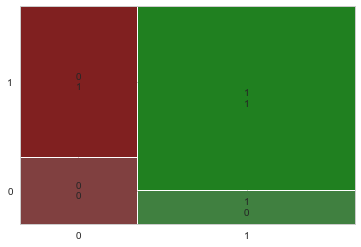

retained      0      1
paperless             
0          3290   7520
1          3039  16952


In [216]:
getcat(['paperless','retained'])

### The majority of retained customers subscribed for paperless communication (only online), however for non-retained customers, the majority did not subscribe to paperless communication. This variable appears to distinguish the classes fairly well.

## Compare categorical variables: 'refill' vs 'retained'
* 1 if customer subscribed for automatic refill

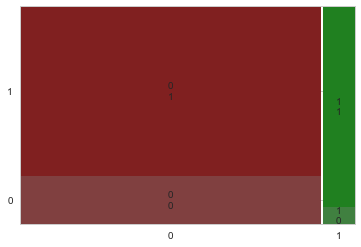

retained     0      1
refill               
0         6105  21767
1          224   2705


In [217]:
getcat(['refill','retained'])

### The majority of retained customers did not subscribe for automatic refill. This variable doesn't appear to distinguish the classes very well.

## Compare categorical variables: 'doorstep' vs 'retained'
* 1 if customer subscribed for doorstep delivery

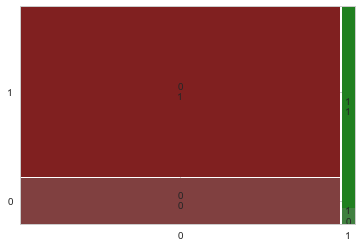

retained     0      1
doorstep             
0         6243  23360
1           86   1112


In [218]:
getcat(['doorstep','retained'])

### The majority of both retained and non-retained customers did not subscribe for doorstep delivery. This variable doesn't appear to distinguish the classes very well.

## Compare categorical variables: 'favday' vs 'retained'
* Customer's favorite delivery day

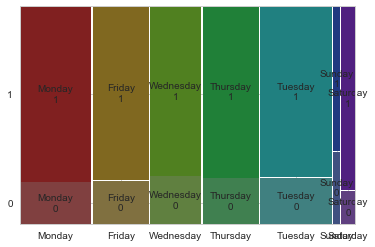

retained      0     1
favday               
Friday     1043  4248
Monday     1295  5467
Saturday    190  1055
Sunday      209   421
Thursday   1112  4178
Tuesday    1422  5333
Wednesday  1058  3770


In [219]:
getcat(['favday','retained'])

### Mondays and Tuesdays were the most preferred days for both retained and non-retained customers. Weekends were the least preferred days for customers. This variable doesn't appear to distinguish the classes very well.

## Compare categorical variables: 'city' vs 'retained'
* City where the customer resides in

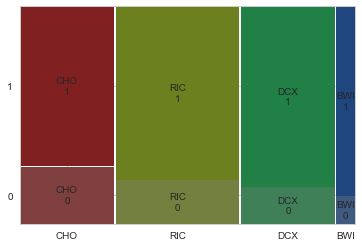

retained     0     1
city                
BWI        214  1484
CHO       2320  6469
DCX       1474  7274
RIC       2321  9245


In [220]:
getcat(['city','retained'])

### This variable doesn't appear to distinguish the classes very well as the proportions by city do not contast much.

## Final Variables used for modeling
* For simplicity, the target variable 'retained' will be renamed to 'y'

In [221]:
# rename class label variable to 'y'
df = df.rename(columns = {'retained': 'y'}) # rename column
# columns to keep
keep_cols = ['y','esent','eopenrate','eclickrate','avgorder','ordfreq','paperless']
data_final = df[keep_cols]
data_final.columns.values

array(['y', 'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq',
       'paperless'], dtype=object)

## Check for Multi-Collinearity

### Variance Inflation Factors

In [222]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# independent variables
X = data_final.loc[:, data_final.columns != 'y']
variables = list(range(X.shape[1]))
vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) for ix in range(X.iloc[:, variables].shape[1])]
pd.DataFrame({'variable': X.columns, 'vif': vif})

,variable,vif
0,esent,2.860604
1,eopenrate,2.492538
2,eclickrate,1.881232
3,avgorder,2.495232
4,ordfreq,1.137011
5,paperless,2.477265


### Correlation matrix

In [223]:
X.corr()

,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless
esent,1.000000,-0.108359,-0.095266,0.114150,0.036033,0.013495
eopenrate,-0.108359,1.000000,0.553335,-0.025192,0.039159,0.238115
eclickrate,-0.095266,0.553335,1.000000,-0.030587,0.062040,0.204439
avgorder,0.114150,-0.025192,-0.030587,1.000000,0.059827,-0.148844
ordfreq,0.036033,0.039159,0.062040,0.059827,1.000000,-0.022509
paperless,0.013495,0.238115,0.204439,-0.148844,-0.022509,1.000000


### There exists some moderate correlation between the independent variables, but all appear to be within acceptable ranges for modeling.

## Over-sampling using SMOTE
* up-sample the non-retained observations using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:

    * Works by creating synthetic samples from the minor class (complex parts) instead of creating copies.
    * Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [224]:
from imblearn.over_sampling import SMOTE
# independent variables
X = data_final.loc[:, data_final.columns != 'y']
# target variable
y = data_final.loc[:, data_final.columns == 'y'].values.ravel()
# set seed for over-sampling
os = SMOTE(random_state=0) 
# train-test split; test set size = 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
os_data_y = pd.DataFrame(data = os_data_y, columns = ['y'])
# check results from over-sampling
print("length of oversampled data is ",len(os_data_X))
print("Number of non-retained customers in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of retained customers in oversampled data",len(os_data_y[os_data_y['y']==1]))
print("Proportion of non-retained customers in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of retained customers in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  34274
Number of non-retained customers in oversampled data 17137
Number of retained customers in oversampled data 17137
Proportion of non-retained customers in oversampled data is  0.5
Proportion of retained customers in oversampled data is  0.5


In [225]:
X = os_data_X
y = os_data_y

## Write Over-Sampled Data to File
* save training data

In [226]:
dat = pd.concat([X, y], axis=1)
dat.to_csv('data.csv')

## Fit a Logistic Regression Model (sklearn)

In [227]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
logreg = LogisticRegression() # negate regularization effect that sklearn applies to logistic regression
logreg.fit(X_train, y_train)

C:\Users\ke392d\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Predicting the test set results and calculating the accuracy

In [228]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


## Confusion Matrix

[[4704  453]
 [ 650 4476]]


Text(0.5, 257.44, 'Predicted label')

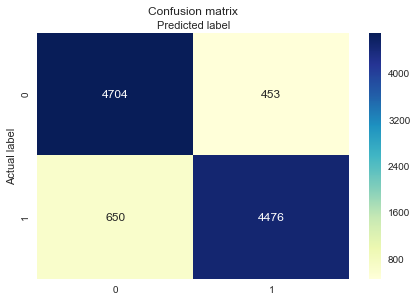

In [229]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
# plot heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap = "YlGnBu", fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Compute precision, recall, F-measure

In [230]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.88      0.91      0.90      5157
           1       0.91      0.87      0.89      5126

    accuracy                           0.89     10283
   macro avg       0.89      0.89      0.89     10283
weighted avg       0.89      0.89      0.89     10283



In [231]:
logreg.intercept_

array([-3.57134328])

In [232]:
logreg.coef_

array([[ 0.1835137 ,  0.0063645 ,  0.01378084, -0.00329958, -0.06070313,
         0.47667634]])

In [233]:
# write training and test data to csv
dat = X_train
dat['y'] = y_train
dat.to_csv("train.csv")
dat = X_test
dat['y'] = y_test
dat.to_csv("test.csv")